In [103]:
import numpy as np
import matplotlib.pyplot as plt
from cpnDISORTlib import *
from cpnRetrievalslib import Bispec_LUT
import cpnCommonlib as cpn

## Previous LUTs

In [106]:
SZA=120
LUT=Bispec_LUT('/umbc/xfs1/zzbatmos/users/charaj1/LES_MSCART_retrievals/LUTs/',\
                   'MODIS_LUT_extended_SZA%03d_RAA000.nc'%(180-int(SZA)))
LUT.readLUT()

In [54]:
LUT.I.shape

(3, 101, 11, 57, 300)

In [62]:
LUT.band[0],LUT.tau[57],LUT.ve[4],LUT.re[20]

(0.86, 5.12861, 0.05, 12.0)

Text(0.5, 0, 'VZA')

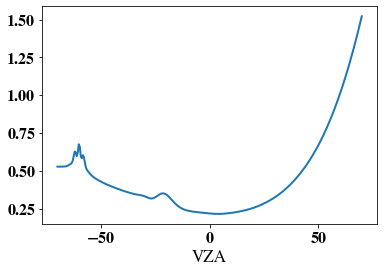

In [141]:
plt.plot(np.hstack((np.ones(150),np.ones(150)*-1))*np.rad2deg(np.arccos(LUT.mu)),LUT.I[0,57,4,21,:])
plt.xlabel('VZA')

#### Testing scattering angle computation

In [73]:
"phi=%f,mu0=%f"%(LUT.phi,LUT.mu0)

'phi=0.000000,mu0=0.500000'

In [95]:
vza=np.rad2deg(np.arccos(LUT.mu))
sza=np.rad2deg(np.arccos(LUT.mu0))
RAA = np.zeros(300,dtype=float)
RAA[150:]=180

In [96]:
sa=scat_ang(180-sza,vza,RAA)

Text(0.5, 0, 'Scattering Angle')

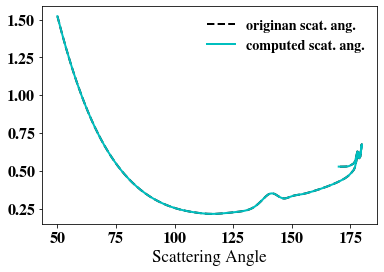

In [140]:
plt.plot(LUT.scat,LUT.I[0,57,4,21,:],'k--',label='originan scat. ang.')
plt.plot(sa,LUT.I[0,57,4,21,:],'c',label='computed scat. ang.')
plt.legend()
plt.xlabel('Scattering Angle')

## From DISOROT

- Note that the correc CER has not been used yet.

In [145]:
I,SZA,SAA,VZA,VAA,ScatA=read_disort()

In [130]:
SZA

array([60.06613744, 60.06613744, 60.06613744, 60.06613744, 60.06613744,
       60.06613744, 60.06613744, 60.06613744, 60.06613744, 60.06613744,
       60.06613744, 60.06613744, 60.06613744, 60.06613744, 60.06613744,
       60.06613744, 60.06613744, 60.06613744, 60.06613744, 60.06613744,
       60.06613744, 60.06613744, 60.06613744, 60.06613744, 60.06613744,
       60.06613744, 60.06613744, 60.06613744, 60.06613744, 60.06613744,
       60.06613744, 60.06613744, 60.06613744, 60.06613744, 60.06613744,
       60.06613744, 60.06613744, 60.06613744, 60.06613744, 60.06613744,
       60.06613744, 60.06613744, 60.06613744, 60.06613744, 60.06613744,
       60.06613744, 60.06613744, 60.06613744, 60.06613744, 60.06613744,
       60.06613744, 60.06613744, 60.06613744, 60.06613744, 60.06613744,
       60.06613744, 60.06613744, 60.06613744, 60.06613744, 60.06613744,
       60.06613744, 60.06613744, 60.06613744, 60.06613744, 60.06613744,
       60.06613744, 60.06613744, 60.06613744, 60.06613744, 60.06

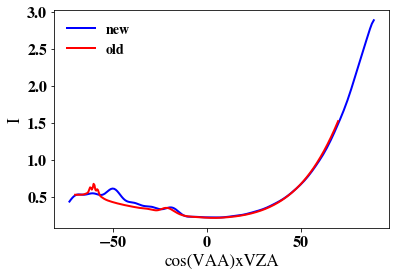

In [146]:
plt.plot(np.cos(np.rad2deg(VAA))*VZA,np.pi*I/np.cos(np.deg2rad(SZA)),'b',label='new')
plt.plot(np.hstack((np.ones(150),np.ones(150)*-1))*np.rad2deg(np.arccos(LUT.mu)),LUT.I[0,57,4,21,:],'r',label='old')
plt.xlabel('cos(VAA)xVZA')
plt.ylabel('I')
plt.legend()

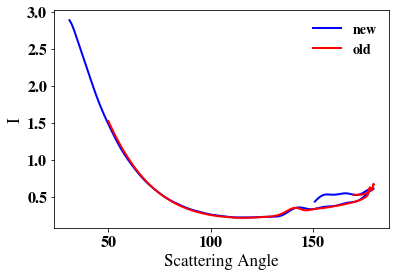

In [147]:
plt.plot(ScatA,np.pi*I/np.cos(np.deg2rad(SZA)),'b',label='new')
plt.plot(LUT.scat,LUT.I[0,57,4,21,:],'r',label='old')
plt.xlabel('Scattering Angle')
plt.ylabel('I')
plt.legend()

## Testing Legendre polynomial expansion of the phase function 

[1] An attempt to compile GETMOM as a Python library.
- To compile for python,
 - f2py -c GETMOM2PY.f90 ERRPACK.f -m GETMOM2PY
 - Did not work properly
 - pmom has to be a fixed-size array in the Fortran code. Made it 900. (line38       REAL      PMOM( 0:900 ) in GETMOM2PY) 
 
[2] Reconstruction of DISORT example Kokhanovsky case phase function

[3] Kokhanovsky cloud phase function

[4] Comparing re-constructed example case [2] with new Legendre expansion results
- Newly computed values are more acurate than DISORT example values

#### [1] An attempt to compile GETMOM as a Python library.

In [2]:
import numpy as np
import  GETMOM2PY as getm
pmom=np.zeros(901)
getm.getmom(7,0.0,900,pmom)

In [ ]:
pmom

#### [2] Reconstruction of DISORT example Kokhanovsky case phase function

In [88]:
from scipy.special import legendre
import time
lm=np.loadtxt('LegMomKkyCld.dat')
I,SZA,SAA,VZA,VAA,ScatA=read_disort()

Text(0.5, 0, 'Number of terms')

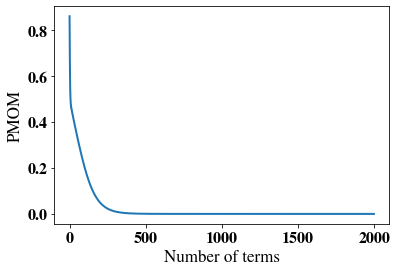

In [101]:
plt.plot(lm)
plt.ylabel('PMOM')
plt.xlabel('Number of terms')

In [89]:
t0 = time.time()
M = np.arange(0,900)
Mu =  np.cos(np.radians(ScatA))
p11_test = 0
for n in M:
    f =  legendre(n)
    L = f(Mu)
    p11_test += (2*n+1)*lm[n]*L
t1 = time.time()
print('%0.2f minutes elapsed!'%((t1-t0)/60))

0.31 minutes elapsed!


Text(0, 0.5, 'phase fuction reconstructed')

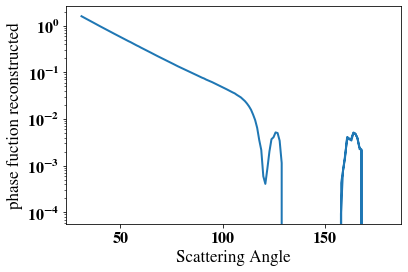

In [90]:
fig,ax = plt.subplots()
ax.plot(ScatA,p11_test)
ax.set_yscale('log')
#ax.set_xlim([0,180])
ax.set_xlabel('Scattering Angle')
ax.set_ylabel(r'phase fuction reconstructed')

#### [3] Kokhanovsky cloud phase function

Reference: /umbc/xfs1/zzbatmos/users/charaj1/taki/ACRS/LUTs/using_DISORT/P11/Zhibo_P11/

normalization 0.9999955506742297


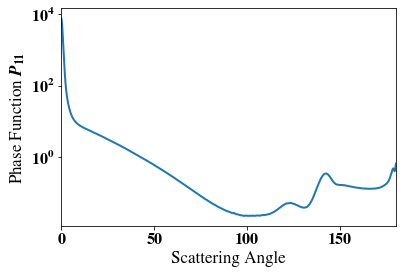

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.special import legendre

Data = np.loadtxt('P11/Zhibo_P11/Kokhanovsky_benchmark_cloud.PDA',skiprows=6)
Ang = Data[:,0]
P11 = Data[:,1]

fig,ax=plt.subplots()

ax.plot(Ang,P11)
ax.set_yscale('log')
ax.set_xlim([0,180])
ax.set_xlabel('Scattering Angle')
ax.set_ylabel(r'Phase Function $P_{11}$')


Mu = np.cos(np.radians(Ang))

# check if the phase function is normalized
C =-0.5*np.trapz(P11,Mu) # negative sign is because the integration should be from -1 to 1, but Mu is from 1 to -1
print('normalization',C)



Text(0, 0.5, 'PMOM')

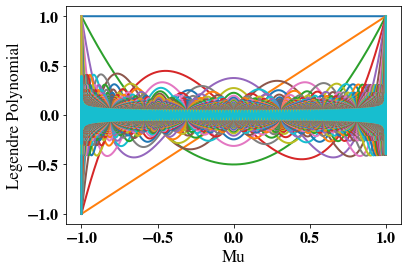

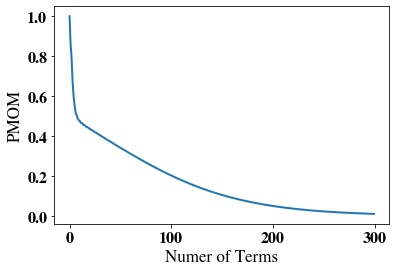

In [80]:
N=np.arange(0,300)
g = []
fig,ax= plt.subplots()
for n in N:
    f =  legendre(n)
    L = f(Mu)
    g.append(-0.5*np.trapz(P11*L,Mu))
    ax.plot(Mu,f(Mu))
ax.set_xlabel('Mu')
ax.set_ylabel(r'Legendre Polynomial')

fig,ax= plt.subplots()
ax.plot(g)
ax.set_xlabel('Numer of Terms')
ax.set_ylabel(r'PMOM')



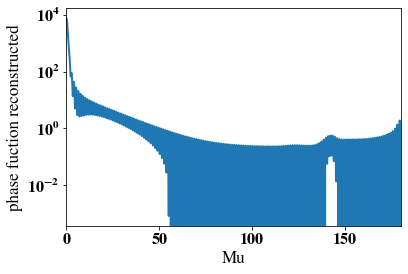

In [81]:
#reconstruct phase fuction with its legendre polynomial expantions
p11_test = 0
for n in N:
    f =  legendre(n)
    L = f(Mu)
    p11_test += (2*n+1)*g[n]*L


fig,ax = plt.subplots()
ax.plot(Ang,p11_test)
ax.set_yscale('log')
ax.set_xlim([0,180])
ax.set_xlabel('Mu')
ax.set_ylabel(r'phase fuction reconstructed')

plt.show()


#### [4] Comparing re-constructed example case in [2] with new Legendre expansion results in [3]

Text(0.5, 1.0, 'PMOM comparison')

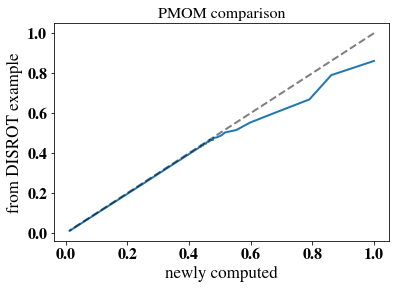

In [102]:
plt.plot(g,lm[:300])
plt.plot(g,g,'k--',alpha=0.5)
plt.xlabel('newly computed')
plt.ylabel('from DISROT example')
plt.title('PMOM comparison')
